<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [ ]:
### Delete dataset exists
import os

folder_path = "./LITS17"
os.system(f"rm -rf {folder_path}")

0

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 368 (delta 95), reused 82 (delta 43), pack-reused 223 (from 1)
Receiving objects: 100% (368/368), 2.11 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (218/218), done.


In [2]:
from kltn.init.install_dependencies import install_packages
install_packages("./kltn")


In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from monai.losses import DiceLoss
from monai.metrics import DiceMetric

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import trainer, val_epoch
from kltn.utils.metrics import EDiceLoss, EDiceLoss_Val
from kltn.models import unet3d, unet3d_cot, unet3d_cot_da, unet3d_rescot_da
from kltn.utils.visualize_results import visualize_results
from kltn.utils.hd95_metrics import calc_hd95

In [4]:
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
log_path = "/content/drive/MyDrive/KLTN/logs"
LOGGER = init_logger(log_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS()

0.10% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 4) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.08% complete (down: 8539.5 kB/s up: 259.5 kB/s peers: 8) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://academictorrents.com/announce.php)[172

## Load data

In [6]:
source_folder = "/content/LITS17"
full_train_dataset, val_dataset = get_datasets_lits(source_folder=source_folder, seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

105 26


In [7]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

print("Train dataset number of batch:", len(train_loader))
print("Val dataset number of batch:", len(val_loader))

Train dataset number of batch: 105
Val dataset number of batch: 26


In [8]:
for batch in train_loader:
    # Assuming your input data is a 5D tensor (batch_size, channels, deep, height, width)
    data_shape = batch['image'].shape
    label_shape = batch['label'].shape
    print("Data shape in the first batch:", data_shape)
    print("Label shape in the first batch:", label_shape)
    break  # Print only the first batch

Data shape in the first batch: torch.Size([1, 1, 128, 128, 128])
Label shape in the first batch: torch.Size([1, 3, 128, 128, 128])


## Visual data

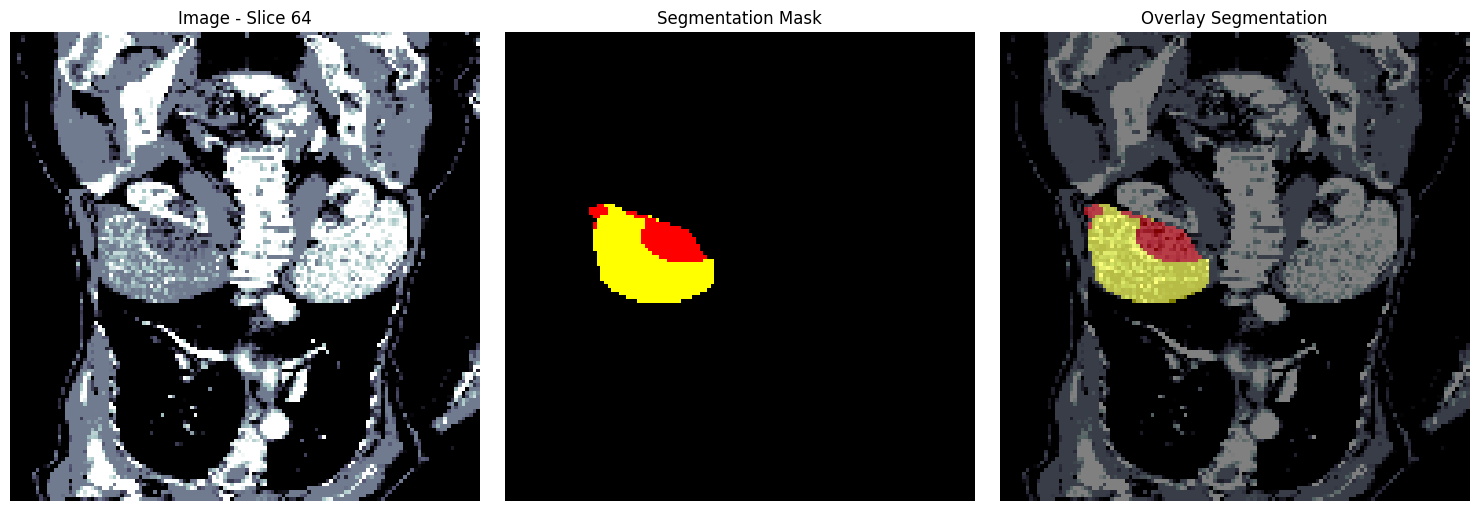

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Define colormap for segmentation classes
cmap = mcolors.ListedColormap(["black", "yellow", "red", "green", "blue", "purple"])
bounds = [0, 1, 2, 3, 4, 5]  # Giới hạn các lớp (0-background, 1-class1, 2-class2,...)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

for batch in train_loader:
    image_sample = batch['image']  # Shape: [1, 1, 128, 128, 128]
    label_sample = batch['label']  # Shape: [1, 3, 128, 128, 128]

    slice_idx = image_sample.shape[2] // 2

    img_slice = image_sample[0, 0, slice_idx, :, :].numpy()
    label_slice = label_sample[0, :, slice_idx, :, :].argmax(0).numpy()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 3 hình ngang

    # Hình 1: Ảnh gốc
    axes[0].imshow(img_slice, cmap=plt.cm.bone)
    axes[0].set_title(f"Image - Slice {slice_idx}")
    axes[0].axis("off")

    # Hình 2: Mask phân đoạn
    axes[1].imshow(label_slice, cmap=cmap, norm=norm)
    axes[1].set_title("Segmentation Mask")
    axes[1].axis("off")

    # Hình 3: Overlay ảnh gốc + Mask
    axes[2].imshow(img_slice, cmap=plt.cm.bone)
    axes[2].imshow(label_slice, cmap=cmap, norm=norm, alpha=0.5)
    axes[2].set_title("Overlay Segmentation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()
    break  # Chỉ hiển thị batch đầu tiên

## Model

In [9]:
model = unet3d.UNet3D(in_channels=1, n_classes=3, n_channels=16).to(device)
print('Number of network parameters:', sum(param.numel() for param in model.parameters()))

Number of network parameters: 2512515


## Training

In [47]:
start_epoch = 1
max_epochs = 1 # 100
batch_size = 1
val_every = 1

criterion = EDiceLoss().to(device)
criterion_val = EDiceLoss_Val().to(device)
metric = criterion_val.metric

# loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)


# dice_acc = DiceMetric(include_background=False, reduction='none', get_not_nans=True)
dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
path_save_model = "/content/drive/MyDrive/KLTN/code/weight"

In [11]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(val_acc_max, dice_liver, dice_tumor,
    dices_avg,loss_epochs, trains_epoch,
) = trainer(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    loss_func = criterion,
    acc_func = dice_acc,
    criterion_val = criterion_val,
    metric = metric,
    scheduler = scheduler,
    batch_size = batch_size,
    max_epochs = max_epochs,
    start_epoch = start_epoch,
    val_every = val_every,
    path_save_model = path_save_model,
    logger = LOGGER,
    )

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/1 1/105 loss: 0.9477 time 5.38s
Epoch 1/1 2/105 loss: 0.8754 time 4.66s
Epoch 1/1 3/105 loss: 0.8308 time 13.71s
Epoch 1/1 4/105 loss: 0.8031 time 7.08s
Epoch 1/1 5/105 loss: 0.7852 time 13.02s
Epoch 1/1 6/105 loss: 0.7723 time 5.86s
Epoch 1/1 7/105 loss: 0.7622 time 3.38s
Epoch 1/1 8/105 loss: 0.7542 time 14.23s
Epoch 1/1 9/105 loss: 0.7478 time 11.85s
Epoch 1/1 10/105 loss: 0.7437 time 4.66s
Epoch 1/1 11/105 loss: 0.7388 time 4.38s
Epoch 1/1 12/105 loss: 0.7343 time 9.43s
Epoch 1/1 13/105 loss: 0.7304 time 1.67s
Epoch 1/1 14/105 loss: 0.7266 time 2.88s
Epoch 1/1 15/105 loss: 0.7232 time 7.31s
Epoch 1/1 16/105 loss: 0.7201 time 5.58s
Epoch 1/1 17/105 loss: 0.7172 time 2.15s
Epoch 1/1 18/105 loss: 0.7144 time 7.92s
Epoch 1/1 19/105 loss: 0.7117 time 10.66s
Epoch 1/1 20/105 loss: 0.7092 time 11.31s
Epoch 1/1 21/105 loss: 0.7068 time 6.35s
Epoch 1/1 22/105 loss: 0.7048 time 1.02s
Epoch 1/1 23/105 loss: 0.7026 time 7.87s
Epoch 1/1 24/105 loss: 0.7004 time 6.60s
Epoch 1/1 25/105 lo

Final training epochs: 1/1 ---[loss: 0.6085] ---[time 661.96s]
INFO:kltn.utils.logger:Final training epochs: 1/1 ---[loss: 0.6085] ---[time 661.96s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/1 105/105 loss: 0.6085 time 2.84s


Val 1/1 1/26, Dice_Avg: 0.000000, time 11.06s
INFO:kltn.utils.logger:Val 1/1 1/26, Dice_Avg: 0.000000, time 11.06s
Val 1/1 2/26, Dice_Avg: 0.000000, time 0.40s
INFO:kltn.utils.logger:Val 1/1 2/26, Dice_Avg: 0.000000, time 0.40s
Val 1/1 3/26, Dice_Avg: 0.000000, time 2.83s
INFO:kltn.utils.logger:Val 1/1 3/26, Dice_Avg: 0.000000, time 2.83s
Val 1/1 4/26, Dice_Avg: 0.000000, time 2.46s
INFO:kltn.utils.logger:Val 1/1 4/26, Dice_Avg: 0.000000, time 2.46s
Val 1/1 5/26, Dice_Avg: 0.000000, time 2.12s
INFO:kltn.utils.logger:Val 1/1 5/26, Dice_Avg: 0.000000, time 2.12s
Val 1/1 6/26, Dice_Avg: 0.000000, time 7.95s
INFO:kltn.utils.logger:Val 1/1 6/26, Dice_Avg: 0.000000, time 7.95s
Val 1/1 7/26, Dice_Avg: 0.000000, time 7.37s
INFO:kltn.utils.logger:Val 1/1 7/26, Dice_Avg: 0.000000, time 7.37s
Val 1/1 8/26, Dice_Avg: 0.000000, time 1.80s
INFO:kltn.utils.logger:Val 1/1 8/26, Dice_Avg: 0.000000, time 1.80s
Val 1/1 9/26, Dice_Avg: 0.000000, time 8.76s
INFO:kltn.utils.logger:Val 1/1 9/26, Dice_Avg: 0.

TypeError: unsupported format string passed to numpy.ndarray.__format__

## Visualize Results

In [ ]:
import glob
print(glob.glob(f"{path_save_model}/best_metric_model*"))

['/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth']


val_output:  torch.Size([1, 2, 128, 128, 128])
val_output:  torch.Size([2, 128, 128, 128])


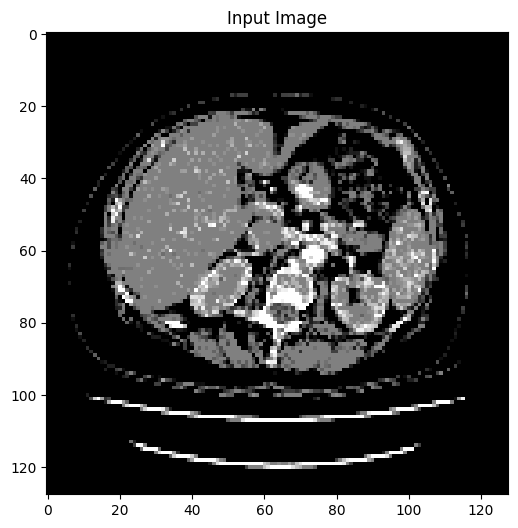

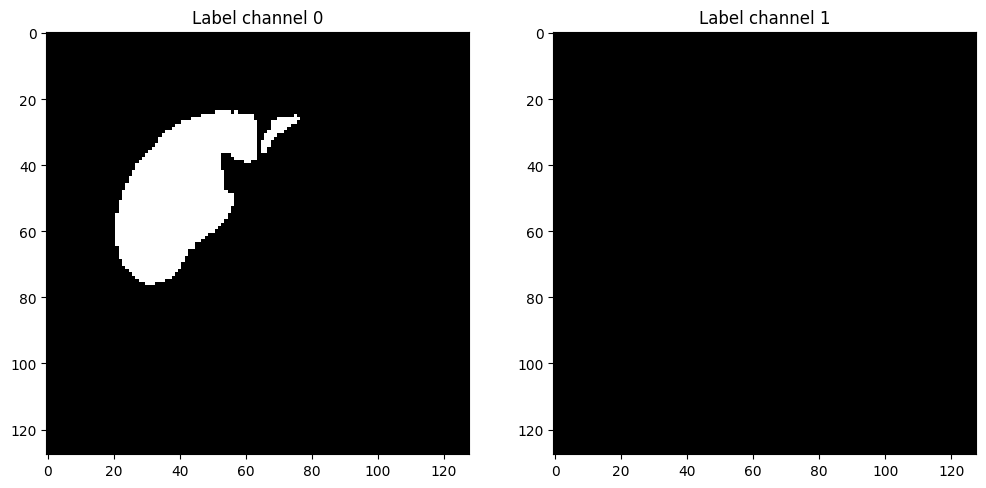

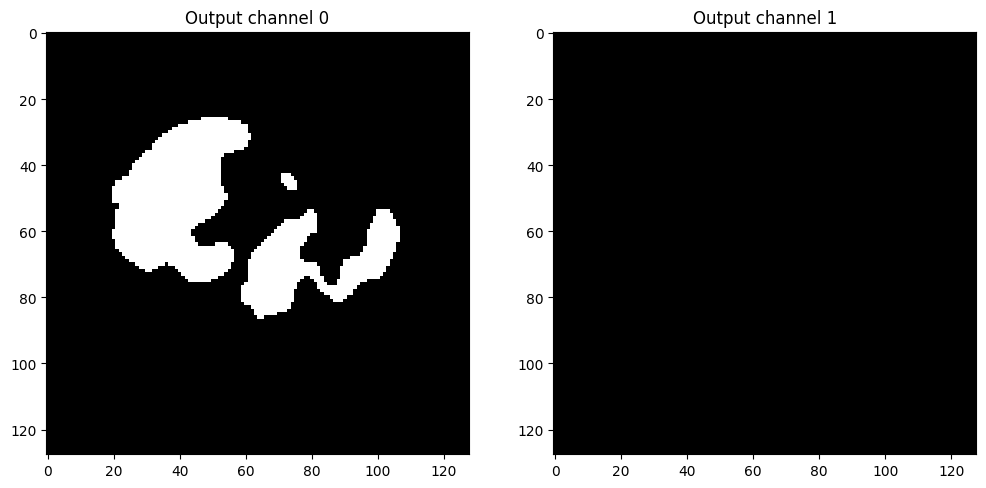

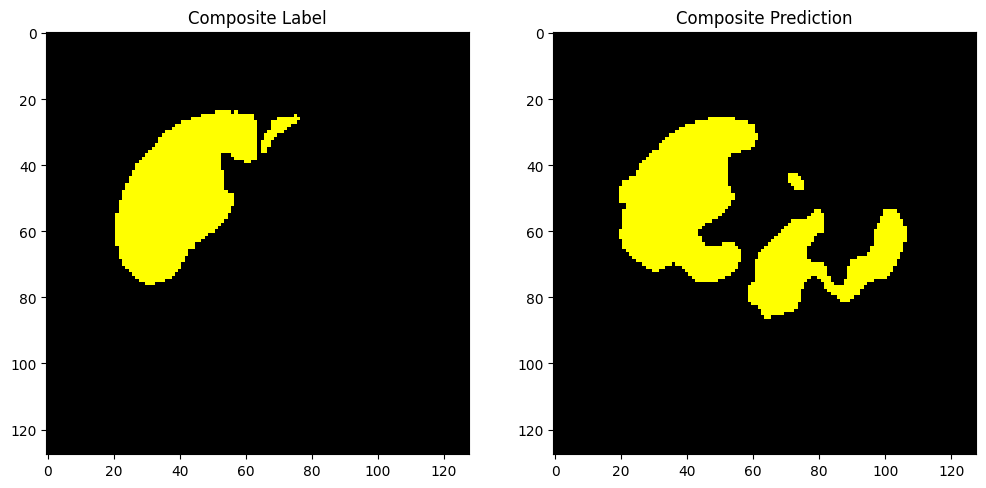

In [ ]:
num_images = 1
weight_path = "/content/drive/MyDrive/KLTN/code/weight/best_metric_model_UNet3D.pth"
visualize_results(model, val_loader, weight_path, num_images, device)